In [1]:
# Moduły

import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.animation as ani

ZADANIE 1 - modelowanie gazu bez oddziaływań międzycząsteczkowych

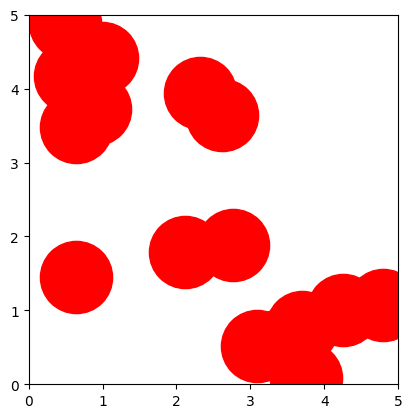

In [18]:
dt = 0.0001

# KLASA CZĄSTKI

class particle:
    def __init__(self, pos, velo):
        self.x = pos
        self.v = velo

# Funkcja zmiany położenia o 1 "krok" przy braku sił

    def step(self):
        self.x[0] += self.v[0] * dt
        if(self.x[0] < 0):
            self.x[0] += 5
        if(self.x[0] > 5):
            self.x[0] -= 5

        self.x[1] += self.v[1] * dt
        if(self.x[1] < 0):
            self.x[1] += 5
        if(self.x[1] > 5):
            self.x[1] -= 5 

# STWORZENIE LISTY CZĄSTEK

partNum = 16 # kwadrat to ma być
particles = []

for i in range(partNum): # ustalamy położenia (siatka) i prędkości (z rozkładu) początkowe
    posit = [i // np.sqrt(partNum) + 1, i % np.sqrt(partNum) + 1] # zapełniamy na początku x = 0, potem x = 1 itd.
    velocity = np.random.uniform(-1, 1, 2)
    A = particle(posit, velocity)
    particles.append(A)

# MODEL RUCHU JEDNOSTAJNEGO BEZ ZDERZEŃ

totalTime = 8
frPrint = 500 # co która klatka trafia do animacji
fr = np.empty([math.floor(totalTime / dt / 500) + 1, partNum, 2]) # liczba klatek, liczba cząstek,  dwie współrzędne każdej cząstki

# Aplikujemy funkcję step na każdej cząstce, aż się skończy czas i dodajemy co "frPrint" klatkę do animacji

indx = 0
for t in np.arange(0, totalTime, dt):
    if indx % frPrint == 0:
        frame = [P.x for P in particles]
        fr[indx // frPrint, :, :] = frame
    for P in particles:
        P.step()
    indx += 1

# ANIMACJA

background = plt.figure()   # tworzymy figurę
fig = plt.axes(xlim = [0, 5], ylim = [0, 5]) # tworzymy tło
fig.set_box_aspect(1)

points = []
for i in range(partNum):
    point = fig.scatter([],[], s = 2700, color = 'red') #
    points.append(point)

def animate(i):
    for p in range(partNum):
        points[p].set_offsets([fr[i, p, 0], fr[i, p, 1]])
    return points

anim = ani.FuncAnimation(background, animate, frames = math.floor(totalTime / dt / frPrint), interval = 200, blit = 'True')
anim.save('Gaz bez sił.gif', writer = 'ffmpeg', fps = 30)

ZADANIE 2 - modelowanie gazu oddziałującego siłami Lennarda - Jonesa

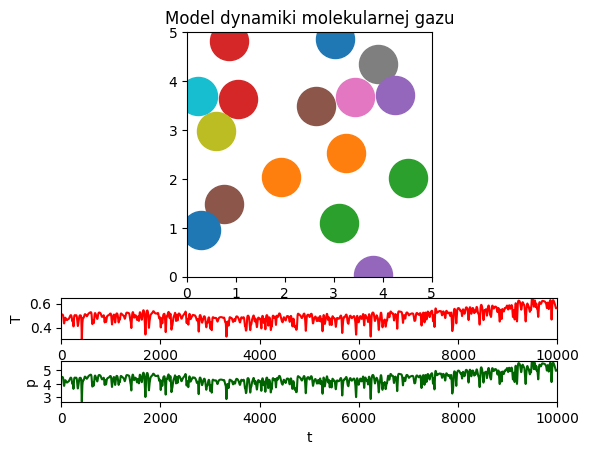

In [17]:
# Jeszcze raz klasa, bo mogę

class molecule:
    def __init__(self, pos, velo):
        self.x = pos
        self.v = velo

# FUNKCJE

# odległość między dwoma cząsteczkami

def d(P1, P2):
    return np.sqrt((P1.x[0] - P2.x[0])**2 + (P1.x[1] - P2.x[1])**2)

# funkcja przyspieszenia jakie odczuwa cząstka "m1" wskutek działania siły od cząstki "m2"

m = 1 # masa cząstki
r = 0.75 # promień cząstki

def acc(P1, P2):
    if d(P1, P2) > 2.5 * r:
        return np.array((0, 0))
    else:
        a = 48 / r * ((r / d(P1, P2))**13 - 0.5 * (r / d(P1, P2))**7) / m
        a1 = a / d(P1, P2) * (P1.x[0] - P2.x[0])
        a2 = a / d(P1, P2) * (P1.x[1] - P2.x[1])
        return np.array((a1, a2))

# Funkcje żabki; prędkość wyprzedza drogę o pół fazy

dt = 0.001 # ważne, czas kroku!!! względnie krok czasowy

def xStep(P):
    x1 = P.x[0] + P.v[0] * dt
    if(x1 > 5):
        x1 -= 5
    if(x1 < 0):
        x1 += 5

    x2 = P.x[1] + P.v[1] * dt
    if(x2 > 5):
        x2 -= 5
    if(x2 < 0):
        x2 += 5

    return [x1, x2]

def vStep (P, acceleration):
    v1 = P.v[0] + acceleration[0] * dt
    v2 = P.v[1] + acceleration[1] * dt
    return [v1, v2]

# STWORZENIE LISTY CZĄSTEK

molNum = 16 # kwadrat to ma być
molecules = []

for i in range(molNum): # ustalamy położenia (siatka) i prędkości (z rozkładu) początkowe
    posit = [i // np.sqrt(molNum) + 1, i % np.sqrt(molNum) + 1] # zapełniamy na początku x = 0, potem x = 1 itd.
    velocity = np.random.uniform(-5, 5, 2)
    A = molecule(posit, velocity)
    molecules.append(A)

# OBLICZENIA NUMERYCZNE

totTime = 10
timeToPrint = 20

klatki = np.empty([math.floor(totTime / dt / timeToPrint) + 1, molNum, 2]) # liczba klatek, liczba cząstek,  dwie współrzędne każdej cząstki
temperature = []
pressure = np.zeros(math.floor(totTime / dt))

for steps in range(math.floor(totTime / dt)):

    if(steps % timeToPrint == 0): # printujemy co timeToPrint klatkę
        klatka = [P.x for P in molecules]
        klatki[steps // timeToPrint, :, :] = klatka

    kinEnergy = 0
    boltzmann = 13.8 # przyjmując masę cząstki na 1 = 10^-26 kg

    for Pn, P in enumerate(molecules): # dla każdej cząstki

        kinEnergy += (P.v[0]**2 + P.v[1]**2)
        r0 = P.x.copy() # zapisujemy dla potomnosci poprzednie położenie cząstki
        molecules[Pn].x = xStep(P)
        accTotal = np.array((0., 0.))
        for Rn, R in enumerate(molecules): # liczymy przyspieszenie od każdej innej cząstki

            if Rn != Pn:    # nie liczymy samoprzyspieszenia
                Q = molecule(R.x.copy(), R.v.copy()) # tworzymy wirtualną cząstkę, by reprezentowała ona kopię cząstki R najbliższą cząstce P

                if P.x[0] - Q.x[0] > 2.5:
                    Q.x[0] += 5
                elif P.x[0] - Q.x[0] < -2.5:
                    Q.x[0] -= 5

                if P.x[1] - Q.x[1] > 2.5:
                    Q.x[1] += 5
                elif P.x[1] - Q.x[1] < -2.5:
                    Q.x[1] -= 5

                accTotal += acc(P, Q) # i dodajemy wkład od tej najbliższej wirtualnej cząstki
        
        molecules[Pn].v = vStep(P, accTotal)
        r1 = P.x.copy()

        b1 = r1[0] - r0[0]
        b2 = r1[1] - r0[1]
        if b1 <= -2.5:
            b1 = 5 + b1
        if b1 >= 2.5:
            b1 = 5 - b1
        if b2 <= -2.5:
            b2 = 5 + b2
        if b2 >= 2.5:
            b2 = 5 - b2

        W = (b1) * accTotal[0] * m + (b2) * accTotal[1] * m
        pressure[steps] += W

    temperature.append(kinEnergy / 2 / molNum / boltzmann)

temperature = np.array(temperature)
pressure *= 0.02
tempToAdd = molNum * boltzmann / 25 * np.array(temperature).copy()
pressure += tempToAdd

# ANIMACJA

background, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw = {'height_ratios' : [6, 1, 1]})   # tworzymy figurę

ax1.set_ylim(0, 5)
ax1.set_xlim(0, 5)
ax1.set_aspect(1)
ax1.set_title('Model dynamiki molekularnej gazu')

tempPic, = ax2.plot([], [], color = 'red')
ax2.set_xlim(0, len(temperature))
ax2.set_ylim(min(temperature), max(temperature))
ax2.set_xlabel("t")
ax2.set_ylabel("T")

pressPic, = ax3.plot([], [], color = 'darkgreen')
ax3.set_xlim(0, len(temperature))
ax3.set_ylim(min(pressure), max(pressure))
ax3.set_xlabel("t")
ax3.set_ylabel("p")

Pics = [tempPic, pressPic]
for i in range(molNum):
    Pics.append(ax1.scatter([], [], s = 750))

def animate(i):
    Pics[0].set_data([range(len(temperature[0 : timeToPrint * i]))], temperature[0 : timeToPrint * i])
    Pics[1].set_data([range(len(pressure[0 : timeToPrint * i]))], pressure[0 : timeToPrint * i])
    for p in range (2, molNum + 2):
        Pics[p].set_offsets([klatki[i, p - 2, 0], klatki[i, p - 2, 1]])
    return Pics

anim = ani.FuncAnimation(background, animate, frames = math.floor(totTime / dt / timeToPrint), interval = 200, blit = 'True')
anim.save('Gaz rzeczywisty.gif', writer = 'ffmpeg', fps = 30)
